In [1]:
import numpy as np
import pandas as pd
import humap
import umap
import time
import nptsne

import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from nptsne import hsne_analysis

from scipy.spatial import procrustes

In [2]:
X_all, y_all = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
X, _, y, _ = train_test_split(X_all, y_all, test_size=0.5, random_state=0)
X = normalize(X)
y = y.astype(int)

# HSNE

In [4]:
hsne = nptsne.HSne(True)
hsne.create_hsne(X, 3)

nlevel0 = hsne.get_scale(0).num_points
nlevel1 = hsne.get_scale(1).num_points
nlevel2 = hsne.get_scale(2).num_points

In [5]:
container = hsne_analysis.AnalysisModel(hsne, hsne_analysis.EmbedderType.GPU)
analysis_level2 = container.top_analysis
for i in range(500):
    analysis_level2.do_iteration()

In [6]:
analysis_level1 = container.add_new_analysis(analysis_level2, np.arange(nlevel2))
for i in range(500):
    analysis_level1.do_iteration()

In [7]:
analysis_level0 = container.add_new_analysis(analysis_level1, np.arange(nlevel1))
for i in range(500):
    analysis_level0.do_iteration()

In [8]:
y[analysis_level2.landmark_orig_indexes]

array([6, 0, 1, ..., 0, 3, 6])

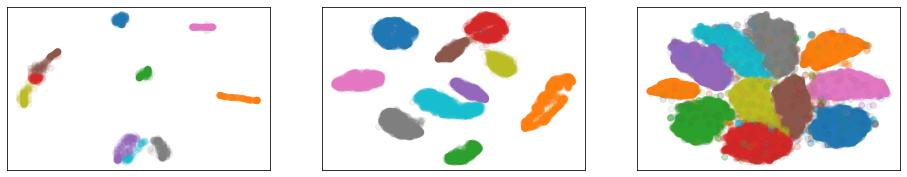

In [9]:
f, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].scatter(analysis_level2.embedding[:, 0], analysis_level2.embedding[:, 1], 
              c=y[analysis_level2.landmark_orig_indexes], alpha=0.1, cmap='tab10')
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax[0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

ax[1].scatter(analysis_level1.embedding[:, 0], analysis_level1.embedding[:, 1], 
              c=y[analysis_level1.landmark_orig_indexes], alpha=0.1, cmap='tab10')
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

ax[2].scatter(analysis_level0.embedding[:, 0], analysis_level0.embedding[:, 1], 
              c=y[analysis_level0.landmark_orig_indexes], alpha=0.1, cmap='tab10')
ax[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

In [10]:
def select_landmarks(indices_level, indices_next_level, embedding):    
    intersect = []
    
    for index in indices_level:
        pos, = np.where(index == indices_next_level)
        if len(pos) > 0:
            intersect.append(embedding[pos[0]])
    
    return np.array(intersect)


def plot_procrustes(embedding_a, embedding_b, y, disparity):
    
    f, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].scatter(embedding_a[:, 0], embedding_a[:, 1], c=y, alpha=0.1, cmap='tab10')
    ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    ax[0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

    ax[1].scatter(embedding_b[:, 0], embedding_b[:, 1], c=y, alpha=0.1, cmap='tab10')
    ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    ax[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
    
    print("Disparity between embeddings: %.5f" % (disparity))

Disparity between embeddings: 0.73500


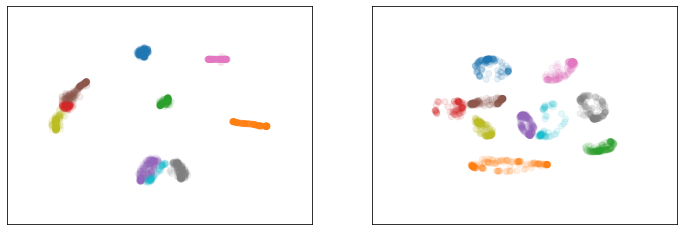

In [11]:
intersect_embedding1 = select_landmarks(analysis_level2.landmark_orig_indexes, 
                                        analysis_level1.landmark_orig_indexes, 
                                        analysis_level1.embedding)

mtx1, mtx2, disparity = procrustes(analysis_level2.embedding, intersect_embedding1)
plot_procrustes(mtx1, mtx2, y[analysis_level2.landmark_orig_indexes], disparity)

Disparity between embeddings: 0.70425


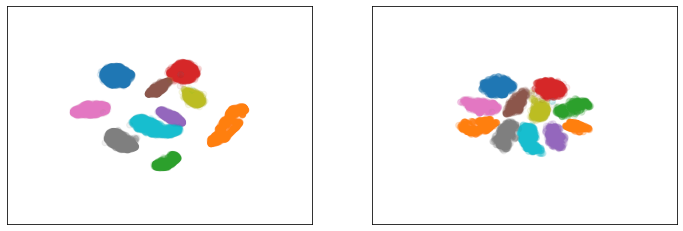

In [12]:
intersect_embedding0 = select_landmarks(analysis_level1.landmark_orig_indexes,
                                        analysis_level0.landmark_orig_indexes,
                                        analysis_level0.embedding)

mtx1, mtx2, disparity = procrustes(analysis_level1.embedding, intersect_embedding0)
plot_procrustes(mtx1, mtx2, y[analysis_level1.landmark_orig_indexes], disparity)

# HUMAP

In [13]:
hreducer = humap.HUMAP(np.array([nlevel1/nlevel0, nlevel2/nlevel1]), verbose=1)
hreducer.fit(X, y)

In [14]:
indices_level2 = hreducer.original_indices(2)
indices_level1 = hreducer.original_indices(1)
indices_level0 = np.arange(X.shape[0]).astype(int)

In [15]:
embedding2 = hreducer.transform(2)
y2 = hreducer.labels(2)

In [16]:

hreducer.set_fixing_term(0.01)
hreducer.fix_datapoints(embedding2)

embedding1 = hreducer.transform(1)
y1 = hreducer.labels(1)

In [17]:
hreducer.set_fixing_term(0.01)
hreducer.fix_datapoints(embedding1)

embedding0 = hreducer.transform(0)
y0 = y

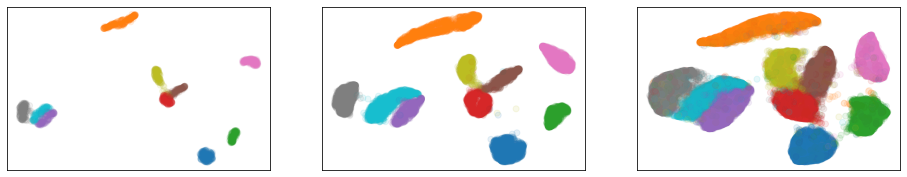

In [18]:
f, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].scatter(embedding2[:, 0], embedding2[:, 1], c=y2, alpha=0.1, cmap='tab10')
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax[0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

ax[1].scatter(embedding1[:, 0], embedding1[:, 1], c=y1, alpha=0.1, cmap='tab10')
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

ax[2].scatter(embedding0[:, 0], embedding0[:, 1], c=y0, alpha=0.1, cmap='tab10')
ax[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

Disparity between embeddings: 0.07654


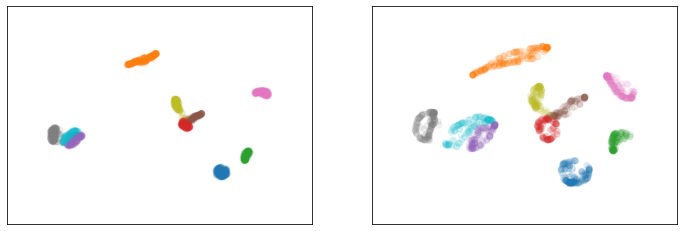

In [19]:
intersect_embedding1 = select_landmarks(indices_level2, 
                                        indices_level1, 
                                        embedding1)

mtx1, mtx2, disparity = procrustes(embedding2, intersect_embedding1)
plot_procrustes(mtx1, mtx2, y2, disparity)

Disparity between embeddings: 0.01307


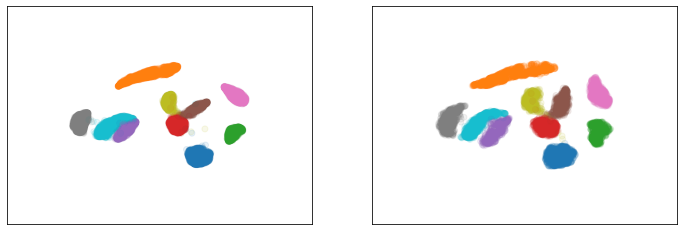

In [20]:
intersect_embedding0 = select_landmarks(indices_level1, 
                                        indices_level0,
                                        embedding0)

mtx1, mtx2, disparity = procrustes(embedding1, intersect_embedding0)
plot_procrustes(mtx1, mtx2, y1, disparity)

# UMAP

In [21]:
X_level2 = X[indices_level2]
X_level1 = X[indices_level1]
X_level0 = X[indices_level0]

In [41]:
umap_reducer = humap.UMAP(n_neighbors=15)
embedding2 = umap_reducer.fit_transform(X_level2)

In [42]:
umap_reducer = humap.UMAP(n_neighbors=15)
embedding1 = umap_reducer.fit_transform(X_level1)

In [43]:
umap_reducer = humap.UMAP(n_neighbors=15)
embedding0 = umap_reducer.fit_transform(X_level0)

In [44]:
embedding2.shape, embedding1.shape, embedding0.shape

((1336, 2), (7385, 2), (35000, 2))

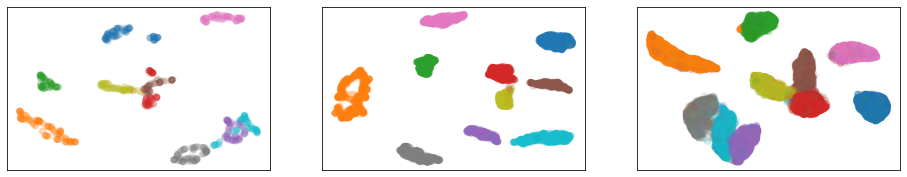

In [45]:
f, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].scatter(embedding2[:, 0], embedding2[:, 1], c=y2, alpha=0.1, cmap='tab10')
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax[0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

ax[1].scatter(embedding1[:, 0], embedding1[:, 1], c=y1, alpha=0.1, cmap='tab10')
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

ax[2].scatter(embedding0[:, 0], embedding0[:, 1], c=y0, alpha=0.1, cmap='tab10')
ax[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

Disparity between embeddings: 0.40013


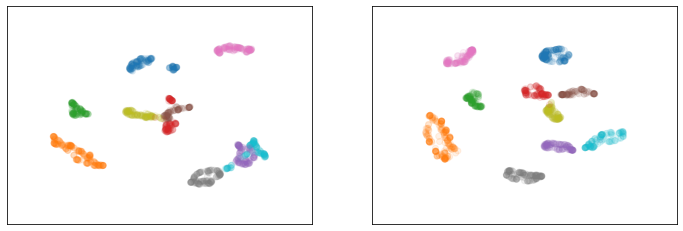

In [46]:
intersect_embedding1 = select_landmarks(indices_level2, 
                                        indices_level1, 
                                        embedding1)

mtx1, mtx2, disparity = procrustes(embedding2, intersect_embedding1)
plot_procrustes(mtx1, mtx2, y2, disparity)

Disparity between embeddings: 0.22940


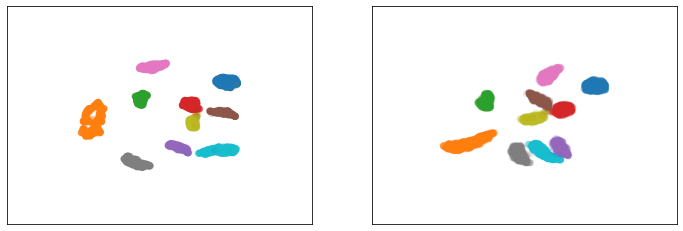

In [47]:
intersect_embedding0 = select_landmarks(indices_level1, 
                                        indices_level0,
                                        embedding0)

mtx1, mtx2, disparity = procrustes(embedding1, intersect_embedding0)
plot_procrustes(mtx1, mtx2, y1, disparity)